# **Recommender Systems and Personalization Datasets**

## Introduzione

Lo scopo di questa analisi è andare a sviluppare un sistema di raccomandazione che, in base alle precedenti valutazioni di un utente, gli suggerisca dei risultati che possono essere interessanti per lui grazie all'analisi di altri utenti con caratteristiche simili.

## Dati

Pacchetti utilizzati per l'analisi.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import gzip

# Surprise e Scikit-Learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Analisi del Dataset

Il dataset che andremo ad utilizzare (`ModCloth`) è una raccolta di recensioni di utenti relative all'acquisto di capi di abbigliamento femminile dal sito web [modcloth.com](https://modcloth.com/). 

In [3]:
# Funzioni per importare file con estensione '.gz'.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


# I dataset contengono recensioni di capi di abbigliamento acquistati su ModCloth.
ModCloth = getDF('data/modcloth_final_data.json.gz')

In [4]:
ModCloth.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29,7,5.0,d,38,34,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,30,36,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,NaN,32,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.00,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [5]:
print(f'Dimensioni del dataset: {ModCloth.shape}')
print(f'Numero di recensioni: {ModCloth.shape[0]}')
print(f'Numero di utenti: {len(ModCloth.user_id.unique())}')
print(f'Numero di prodotti: {len(ModCloth.item_id.unique())}')

Dimensioni del dataset: (82790, 18)
Numero di recensioni: 82790
Numero di utenti: 47958
Numero di prodotti: 1378


Il dataset è formato da 18 variabili che reppresentano principalmente misure e taglie degli utenti che hanno fatto le 82 mila recensioni insieme alle valutazioni dei prodotti. I singoli utenti sono circa 48 mila e le recensioni fanno riferimento a 1378 prodotti differenti.

Variabili:
- **item_id**: unique product id
- **waist**: waist measurement of customer
- **size**: the standardized size of the product
- **quality**: rating for the product
- **cup size**: cup size measurement of customer
- **hips**: hip measurement of customer
- **bra size**: bra size of customer
- **category**: the category of the product
- **bust**: bust measurement of customer
- **height**: height of the customer
- **length**: feedback on the length of the product
- **fit**: fit feedback
- **user_name**: a unique id for the customer
- **shoe size**: shoe size of the customer
- **shoe width**: shoe width of the customer
- **review_text**: review of customer
- **review_summary**: review summary

In [6]:
# Rinominiamo le colonne per eliminare gli spazi tra le parole dei nomi delle variabili.
ModCloth.columns = ['item_id', 'waist', 'size', 'quality', 'cup_size', 'hips', 'bra_size',
                    'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
                    'shoe_size', 'shoe_width', 'review_summary', 'review_text']

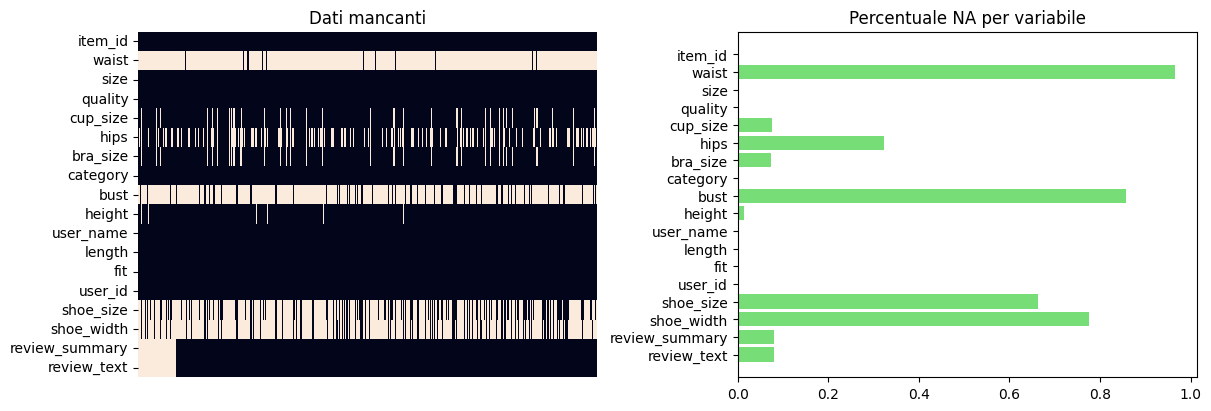

Percentuale di dati mancanti per ogni variabile:


,review_text,review_summary,shoe_width,shoe_size,user_id,fit,length,user_name,height,bust,category,bra_size,hips,cup_size,quality,size,waist,item_id
0,0.08123,0.08123,0.775251,0.662822,0.0,0.0,0.000423,0.0,0.013371,0.856818,0.0,0.07269,0.322817,0.075553,0.000821,0.0,0.965189,0.0


Struttura delle variabili:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  object 
 1   waist           2882 non-null   object 
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup_size        76535 non-null  object 
 5   hips            56064 non-null  object 
 6   bra_size        76772 non-null  object 
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  object 
 14  shoe_size       27915 non-null  object 
 15  shoe_width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  revi

In [7]:
# Visualizzazione valori mancanti.
fig, (ax1, ax2)= plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(12, 4)

# Grafico posizione dati mancati.
sns.heatmap(ax = ax1, data=ModCloth.isna().transpose(), cbar=False)
ax1.set(title='Dati mancanti', xlabel=None)
ax1.set_xticks([])

# Grafico percentuale dati mancanti.
perc_NA = pd.DataFrame(ModCloth.isna().sum() / ModCloth.shape[0])[::-1]
ax2.barh(np.arange(len(perc_NA.index)), perc_NA[0].to_list(), color = '#77DD77')
ax2.set(title='Percentuale NA per variabile')
ax2.set_yticks(np. arange(len(perc_NA)), perc_NA.index)
plt.show()


print('Percentuale di dati mancanti per ogni variabile:')
display(perc_NA.T)

print('Struttura delle variabili:')
ModCloth.info()

All'interno del dataset sono presenti molti valori mancanti, soprattutto in alcune variabili come "waist" e "bust". Solo 6 delle 18 hanno tutti i valori presenti: probabilmente sono valori inseriti di default all'interno della recensione del prodotto.

In [8]:
# Eliminiamo le righe del dataframe che si ripetono.
ModCloth.duplicated().sum()  # ---> 377
ModCloth = ModCloth.drop_duplicates()

Consideriano anche alcuni dati relativi agli utenti e ai capi acquistati.

In [9]:
mean_user = round(ModCloth.groupby('user_id').item_id.count().mean(), 2)
max_user = ModCloth.groupby('user_id').item_id.count().max()
print(f'Numero medio di acquisti per utente: {mean_user}')
print(f'Numero massimo di acquisti fatti da un utente: {max_user}\n')

mean_item = round(ModCloth.groupby('item_id').count().mean()[0], 2)
max_item = ModCloth.groupby('item_id').count().max()[0]
print(f'Numero medio di acquisti di un capo: {mean_item}')
print(f'Numero massimo di acquisti di un capo: {max_item}')

Numero medio di acquisti per utente: 1.72
Numero massimo di acquisti fatti da un utente: 27

Numero medio di acquisti di un capo: 2.09
Numero massimo di acquisti di un capo: 38


### Analisi delle Variabili

Data la loro alta concentrazioni di valori mancanti (maggiore dell'80%) decidiamo di eliminare le variabili "waist" e "bust". Per le variabili "length", "height" e "quality" che invece presentano solo pochi valori mancanti, semplicemente cancelliamo le righe.

In [10]:
# Eliminiamo le colonne superflue.
ModCloth.drop(['waist', 'bust'], axis=1, inplace=True)

# Eliminiamo poche righe con valori mancanti per "length", "height" e "quality".
ModCloth.dropna(subset=['length', 'height', 'quality'], inplace=True)

Osserviamo il comportamento delle variabili categoriche presenti.

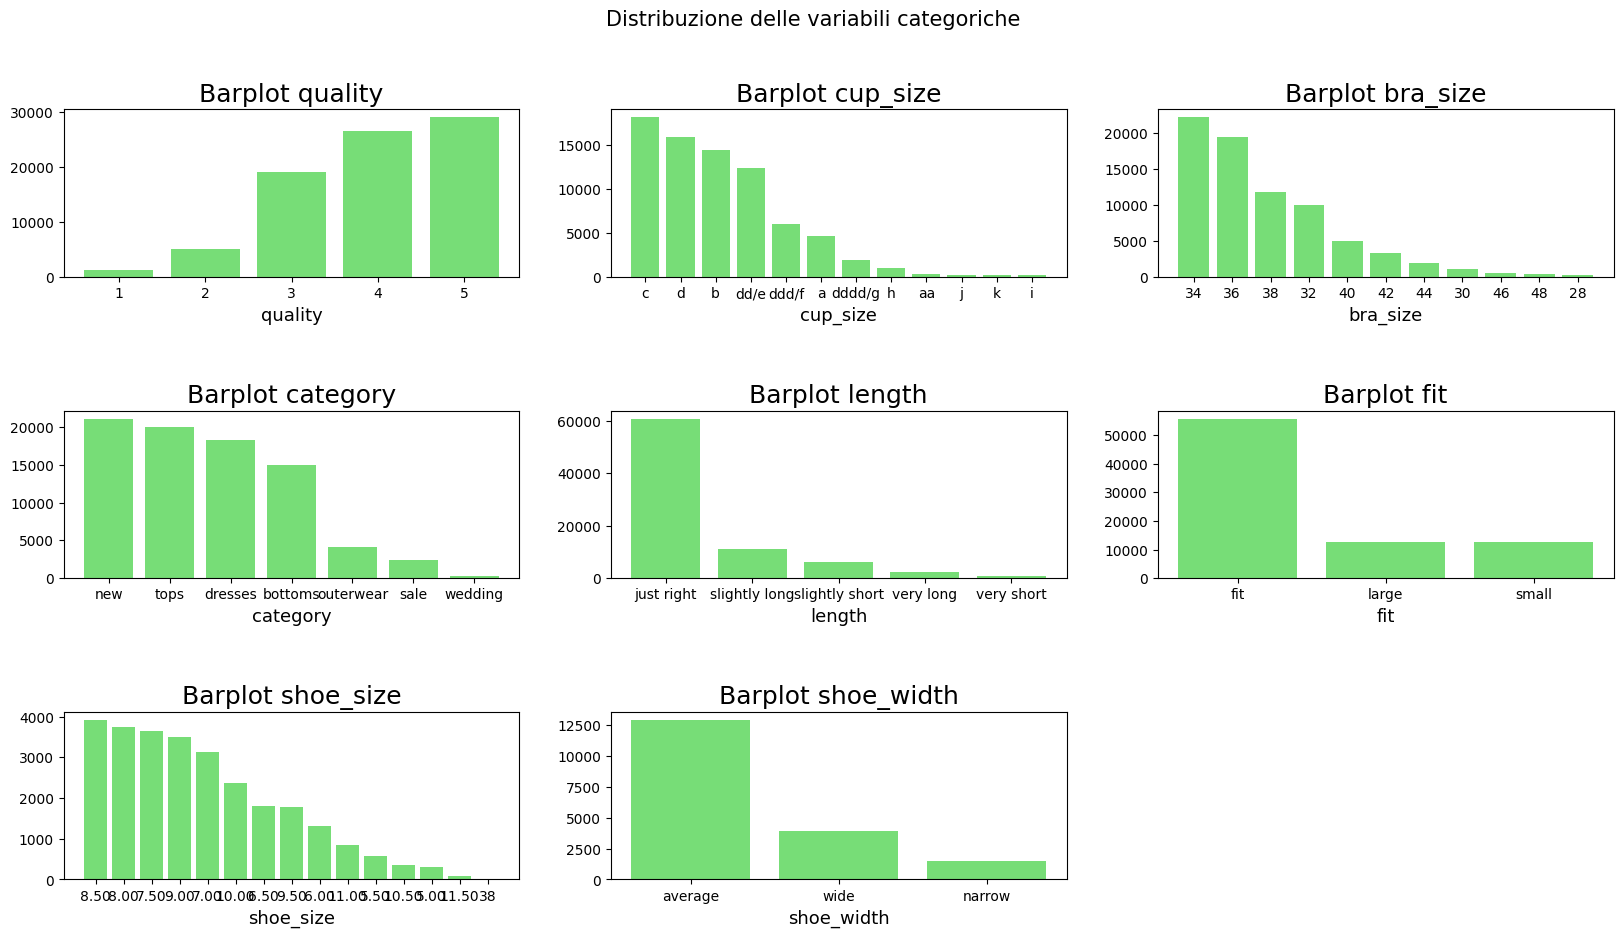

In [11]:
# Funzione che restituisce etichette e altezze del barplot per una variabile categorica.
def barplot_attr(col):
    labels = col.value_counts().index
    h = col.value_counts().values
    return labels, h

# Variabili categoriche.
cat_var = ['quality', 'cup_size', 'bra_size', 'category', 'length', 'fit', 'shoe_size', 'shoe_width']


fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(hspace=.8)
fig.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])

for i in range(1, len(cat_var)+1):
    ax = fig.add_subplot(3, 3, i)
    labels, h = barplot_attr(ModCloth[cat_var[i-1]])
    ax.bar(labels, h, color='#77DD77')
    ax.set_xlabel(cat_var[i-1], fontsize=13)
    ax.set_title(f'Barplot {cat_var[i-1]}', fontsize= 18)

plt.suptitle("Distribuzione delle variabili categoriche", fontsize= 15)
plt.show()

Per la variabile "quality" notiamo come la maggior parte delle recensioni sia valutate positivamente (supponendo 5 positive e 1 negative). le variabili "cup_size" e "bra_size" hanno un andamento simile all'interno delle categorie (variabili entrambe riferite a misure del seno). Per quanto riguarda la categorizzazione dei capi notiamo come quelli più recensiti, e presumibilmente più acquistati, sono quelli che si trovano nella categoria novità e tops (maglie o camicie), piuttosto che non quelli nella categoria sconti come invece si sarebbe potuto pensare. Per quanto riuguarda le misure dei capi la maggir parte degli utenti le ha trovate corrette. Anche per la variabile "shoe_size" troviamo un andamento simile ad alcuni riscontrati prima: questa caratteristica è presente in quelle variabili che presentano molte categorie delle quali alcune sono molto più comuni mentre altre sono rivolte a pochi. Anche la calzabilità delle scarpe, come per quella degli altri capi di abbigliamento, risulta buona per la maggior parte degli utenti ("shoe_width").

Andiamo ora ad osservare come si comportano queste varibili se andiamo ad inserire al posto dei dati mancanti il valore "Unknown".

In [12]:
for var in cat_var:
    ModCloth[var] = ModCloth[var].fillna('Unknown')

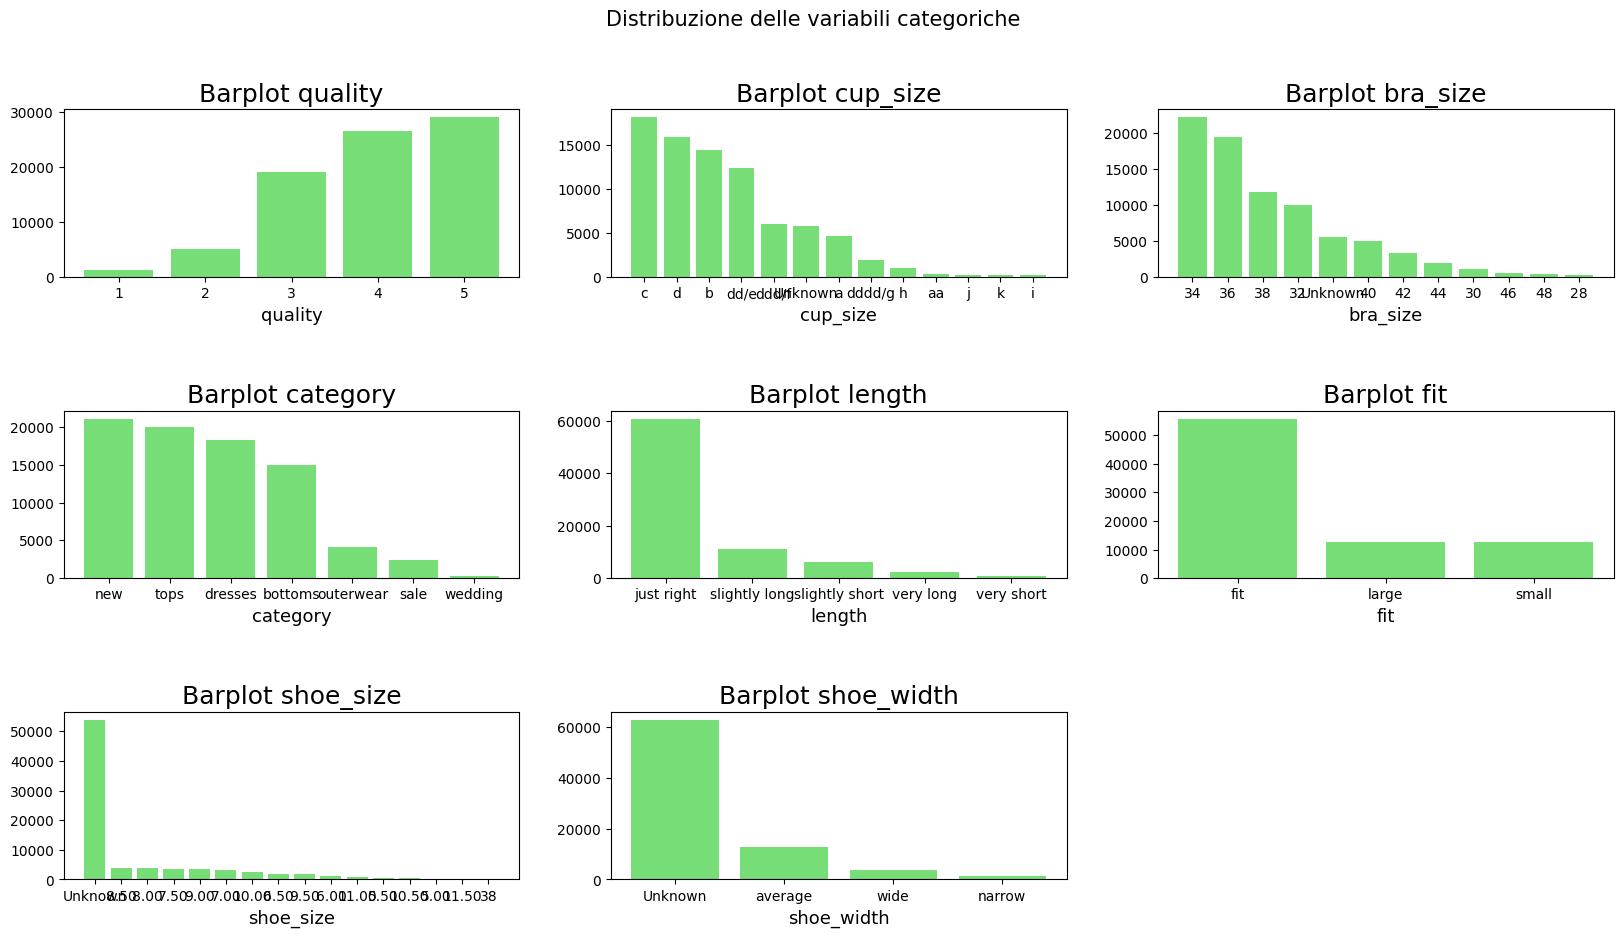

In [13]:
fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(hspace=.8)
fig.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])

for i in range(1, len(cat_var)+1):
    ax = fig.add_subplot(3, 3, i)
    labels, h = barplot_attr(ModCloth[cat_var[i-1]])
    ax.bar(labels, h, color='#77DD77')
    ax.set_xlabel(cat_var[i-1], fontsize=13)
    ax.set_title(f'Barplot {cat_var[i-1]}', fontsize= 18)

plt.suptitle("Distribuzione delle variabili categoriche", fontsize= 15)
plt.show()

Mentre per le variabili *cup_size* e *bra_size* la categoria 'Unknown' ha delle frequenze di dati basse, per le variabili relative alle scarpe ha un impatto rilevante, come ci aspettavamo data l'alta presenza di valori mancanti.
Decidiamo quindi non andare a considerare nemmeno queste due variabili per la successiva analisi.

Vediamo ora le variabili continue come si comportano.

In [14]:
# "height" è in piedi e la riformattiamo in cm.
def ft_to_cm(x):
    if len(x)>3: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    else:
        return (int(x[0])*30.48)

ModCloth.height = ModCloth.height.apply(ft_to_cm)

# Assegnamo ai valori mancanti di "hips" il valore -1.
ModCloth.hips = ModCloth.hips.fillna(-1.0)
ModCloth.hips = ModCloth.hips.astype('float')

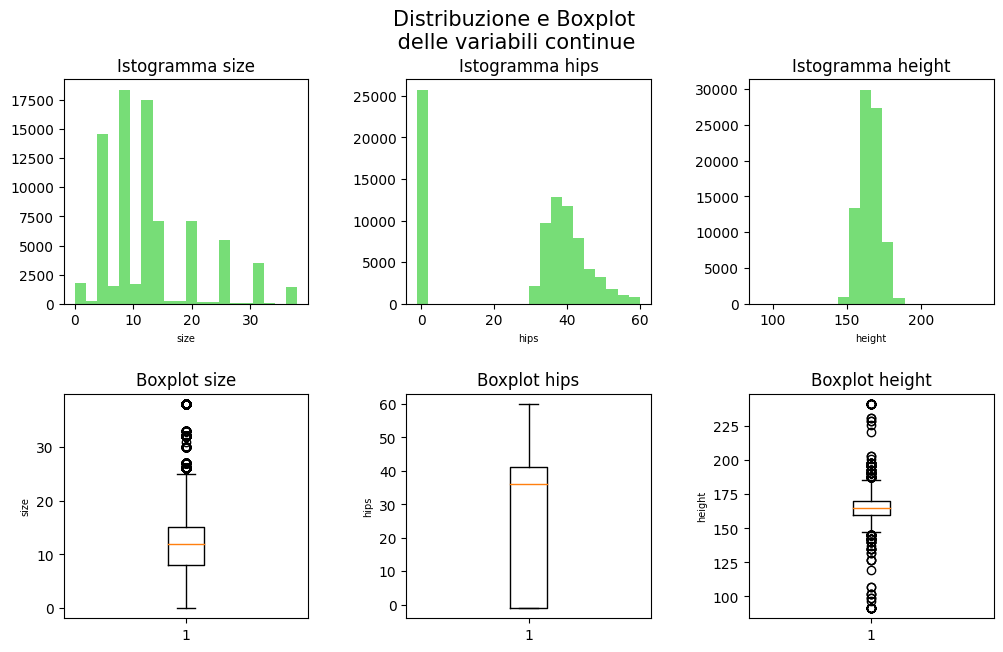

In [15]:
cont_var = ['size', 'hips', 'height']

fig = plt.figure(figsize = (12,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
fig.tight_layout(rect=[0, 0.03, 1, 0.93])

# Istogrammi.
for i in range(1, len(cont_var)+1):
    ax = fig.add_subplot(2, 3, i)
    ax.hist(ModCloth[cont_var[i-1]], color='#77DD77', bins = 20)
    ax.set_xlabel(cont_var[i-1], fontsize=7)
    ax.set_title(f'Istogramma {cont_var[i-1]}', fontsize= 12)

# Boxplot.
for i in range(1, len(cont_var)+1):
    ax = fig.add_subplot(2, 3, i+3)
    ax.boxplot(ModCloth[cont_var[i-1]])
    ax.set_ylabel(cont_var[i-1], fontsize=7)
    ax.set_title(f'Boxplot {cont_var[i-1]}', fontsize= 12)

plt.suptitle("Distribuzione e Boxplot\n delle variabili continue", fontsize= 15)
plt.show()

Per la variabile "size" notiamo subito come, nonostante sia una variabile continua, molte taglie o non sono presenti o sono acquistato con poca frequenza. La distribuzione delle misure della variabile "hips" assume una forma più continua presentando alcuni outliers per valori alti; tutti i valori mancanti sono stati riformattati con il valore -1 e se dovessimo sostituirli con il valore medio sarebbero troppi, andando così a distorcere la forma dell'attuale distribuzione: anche in questo caso decidiamo di scratare la variabile successivamente. La variabile che rappresenta l'altezza invece ("height") ha una distibuzione molto addensata intorno al valore media poichè, come vediamo dal boxplot, presenta svariati outliers sia per valori bassi che per valori alti.

In [16]:
min(ModCloth.height)

91.44

I valori bassi della variabile *height* possiamo considerarli come validi considerando che potrebbero essere stati acquisti per delle bambine, dato che il valore più basso che la variabile assume è 91 cm. Per i valori alti dobbiamo fare un'altra cosiderazione.

In [17]:
ModCloth[ModCloth.height > 220].groupby('user_name').height.max()

user_name
Ida             241.30
Laurence        228.60
Samma           220.98
a.roodman       231.14
angelapye       228.60
bandnerd2522    241.30
colmaggie       241.30
lab262          226.06
Name: height, dtype: float64

In [18]:
ModCloth[ModCloth.height > 220].groupby('user_name').count()

,item_id,size,quality,cup_size,hips,bra_size,category,height,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
user_name,,,,,,,,,,,,,,,
Ida,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Laurence,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Samma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
a.roodman,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
angelapye,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
bandnerd2522,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
colmaggie,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
lab262,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [19]:
ModCloth[ModCloth.user_name == 'bandnerd2522'].mode().loc[0]

item_id                                                      161514
size                                                           12.0
quality                                                         5.0
cup_size                                                          k
hips                                                           60.0
bra_size                                                         48
category                                                       tops
height                                                        241.3
user_name                                              bandnerd2522
length                                                   just right
fit                                                           small
user_id                                                      708288
shoe_size                                                     11.50
shoe_width                                                  average
review_summary                            I LOVE

Non ci sono molti utenti con un'altezza maggiore di 220; notiamo in paritcolare una donna che ha 20 recensioni differenti all'interno del dataset tutte con la stessa altezza. Decidiamo di eliminare questi utenti perchè rappresentano una percentuale minima della nostra popolazione.

In [20]:
ModCloth = ModCloth[ModCloth.height < 220]

Infine le variabili "review_summary" e "review_text" ,essendo testuali, non le andremo a considerare.

Andiamo ad osservare ora come si comportano tra loro le diverse variabili.

In [21]:
def comparative_barplot(data, title, vars):
    labels = data.index
    lab_range = np.arange(len(labels))
    columns = data.columns
    w = 1 / (len(columns)+1)
    for i in range(len(columns)):
        plt.bar(lab_range + w*i, data[columns[i]], width= w, label = columns[i])

    plt.xticks(lab_range + w*(len(columns)//2), labels)
    plt.xlabel(vars[0])
    plt.title(title)
    plt.legend(title=vars[1])

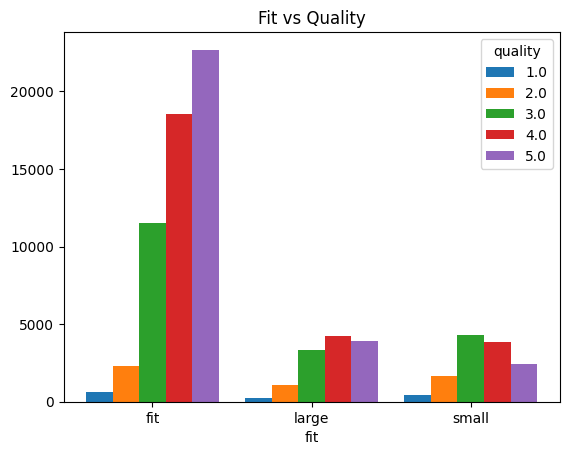

In [22]:
data = ModCloth.groupby('fit').quality.value_counts().unstack()
comparative_barplot(data, 'Fit vs Quality', ['fit', 'quality'])

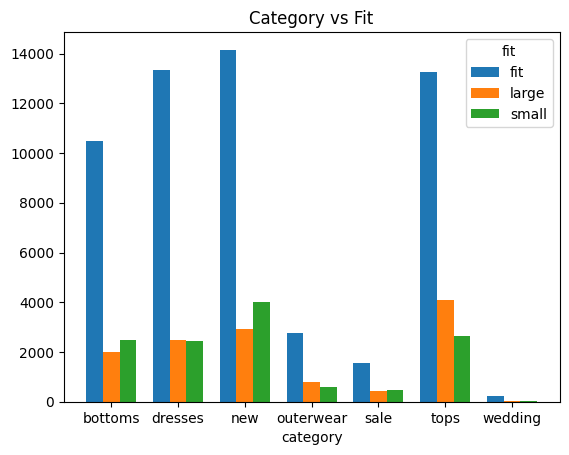

In [23]:
data = ModCloth.groupby('category').fit.value_counts().unstack()
comparative_barplot(data, 'Category vs Fit', ['category', 'fit'])

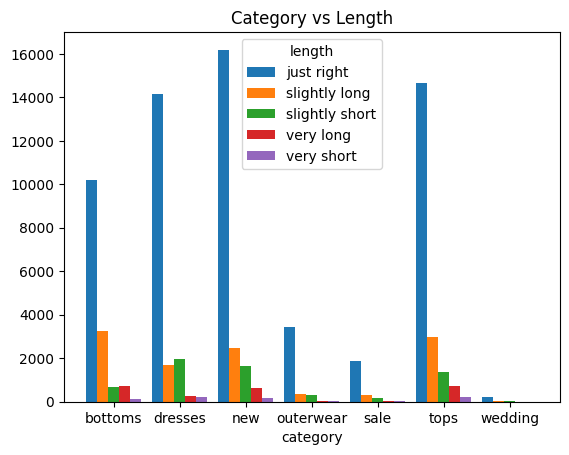

In [24]:
data = ModCloth.groupby('category').length.value_counts().unstack()
comparative_barplot(data, 'Category vs Length', ['category', 'length'])

## Predizione dei Rating

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

[Recomendation system](https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_KNN.ipynb)

In [120]:
a = ModCloth.groupby('user_id').count().item_id

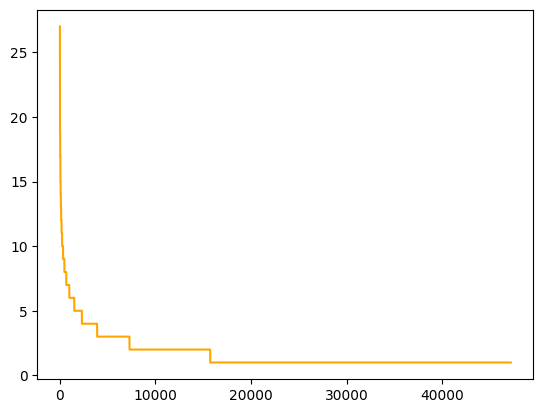

In [121]:
plt.plot(sorted(a.to_list(), reverse=True), color = 'orange');

In [105]:
# Lista delle variabili che utilizziamo per il rating.
data = ModCloth[['size', 'cup_size', 'bra_size','category', 'height', 'length', 'fit', 'quality']]

# Ricodifichiamo le variabili categoriche come dummies (per ogni categoria di ogni variabile creiamo una nuova variabile binaria).
cat_var = ['cup_size', 'bra_size','category', 'length', 'fit']
data = pd.get_dummies(data, columns = cat_var)

X = data.loc[ : , data.columns != 'quality']
Y = data[['quality']]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.1)

# Ricerca del miglior valore di K.
range_k = np.arange(10,30)
RMSE_k = []
for k in tqdm(range_k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE_k.append(mean_squared_error(y_test, y_pred, squared=False))

# Ricerca della migliore metrica.
k_opt = range_k[np.argmin(RMSE_k)]
metrics = ['minkowski', 'cityblock', 'euclidean', 'l1', 'l2', 'manhattan']
RMSE_metric = []
for metric in tqdm(metrics):
    model = KNeighborsClassifier(n_neighbors=k_opt, metric=metric)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE_metric.append(mean_squared_error(y_test, y_pred, squared=False))

100%|██████████| 6/6 [00:24<00:00,  4.02s/it]


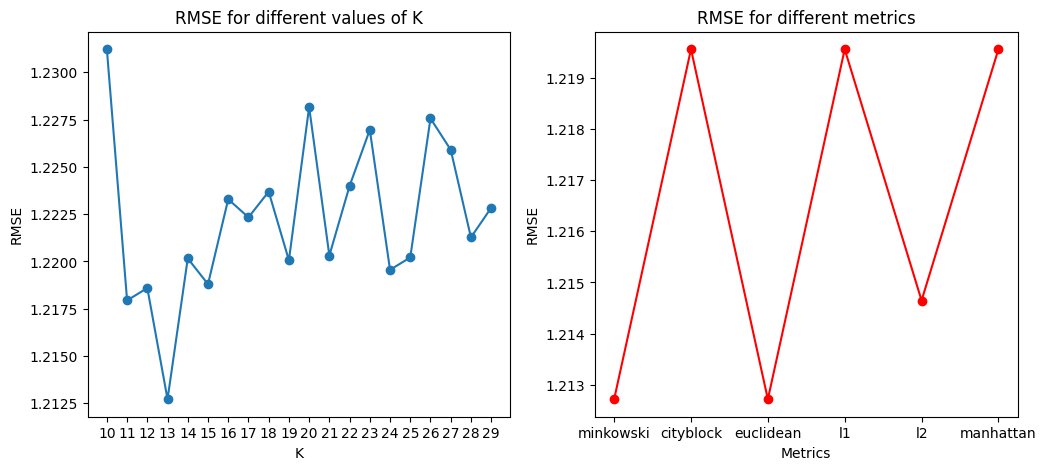

In [118]:
# Plot dei grafici.
fig = plt.figure(figsize = (12,5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range_k, RMSE_k, 'o-')
ax.set_xlabel('K')
ax.set_ylabel('RMSE')
ax.set_xticks(range_k) 
ax.set_xticklabels(range_k)
ax.set_title('RMSE for different values of K')

ax = fig.add_subplot(1, 2, 2)
ax.plot(metrics, RMSE_metric, 'ro-')
ax.set_xlabel('Metrics')
ax.set_ylabel('RMSE')
ax.set_title('RMSE for different metrics')

plt.show()

User-based

In [203]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

Andando a creare la tabella di rating, la maggior parte dei valori è mancante. Per riempire queste celle utilizziamo il valore 2.5 andando così ad inserire una valutaione neutra per ogni dato mancante.

In [204]:
user_rating_table = ModCloth.pivot_table(index='user_id', columns='item_id', values='quality')
user_rating_table_filled = user_rating_table.fillna(2.5)

similarities = cosine_similarity(user_rating_table_filled)
cosine_similarity_df = pd.DataFrame(similarities, index=user_rating_table_filled.index, columns=user_rating_table_filled.index)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
# Instantiate the user KNN model
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)
# Fit the model and predict the target user
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)
print(user_user_pred)

In [180]:
a = [0,1,2,4]
a.notnull()

AttributeError: 'list' object has no attribute 'notnull'

In [170]:
user_item_pivot = ModCloth.pivot_table(index='user_id', columns='item_id', values='quality').fillna(0)
user_item_rating_matrix = csr_matrix(user_item_pivot.values)

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_rating_matrix);

# distance, indices = model_knn.kneighbors(user_item_rating_matrix, n_neighbors=6)

Item-based

In [169]:
item_user_pivot = ModCloth.pivot_table(index='item_id', columns='user_id', values='quality').fillna(0)
item_user_rating_matrix = csr_matrix(item_user_pivot.values)

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(item_user_rating_matrix);

# distance, indices = model_knn.kneighbors(item_user_rating_matrix, n_neighbors=6)

In [165]:
row = indices[0]
user_item_pivot.iloc[row[1:]]

item_id,123373,124024,124124,124761,125353,125442,125602,126560,126885,127008,...,803768,804295,805172,805642,806406,806479,806856,807252,807384,807722
user_id,,,,,,,,,,,,,,,,,,,,,
978959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
766851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
